In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import datetime
import keras.backend as K
K.clear_session()
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [2]:
import pybaseball

pd.set_option('display.max_rows', 1600)
pd.set_option('display.max_columns',1500)
pd.set_option('display.width', 1500)

First let's import keras and some other libraries

In [3]:
pitchers_seasons = pybaseball.pitching_stats(2017,2019)

In [5]:
#pitchers = pybaseball.statcast(start_dt="2018-04-01",end_dt="2020-08-31")
pitchers = pd.read_csv("full_pitching_data_2019_2020.csv")

/Users/nchapman/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
pitchers.dropna(subset=["pitch_type"],inplace=True)

In [7]:
#pitchers.to_csv("full_pitching_data_2019_2020.csv",index=False)

In [8]:
pitchers.sort_values(["pitcher","game_date","at_bat_number","pitch_number"],inplace=True)

In [10]:
## Previous Pitch for Current Pitcher for this At Bat
pitchers["prev_pitch"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["pitch_type"].shift(+1).fillna("FP")
## Previous result for this At Bat
pitchers["prev_result"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["description"].shift(+1).fillna("FP")
## Previous Pitch type for this At Bat
pitchers["prev_type"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["type"].shift(+1).fillna("FP")
## Previous Pitch Speed for this At Bat
pitchers["prev_release_speed"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["release_speed"].shift(+1).fillna(0)
## Previous zone for this at bat
pitchers["prev_zone"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["zone"].shift(+1).fillna("FP")


## Previous Pitch for Current Pitcher for this At Bat
pitchers["prev_pitch2"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["pitch_type"].shift(+2).fillna("FP")
## Previous result for this At Bat
pitchers["prev_result2"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["description"].shift(+2).fillna("FP")
## Previous Pitch type for this At Bat
pitchers["prev_type2"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["type"].shift(+2).fillna("FP")
## Previous Pitch Speed for this At Bat
pitchers["prev_release_speed2"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["release_speed"].shift(+2).fillna(0)
## Previous zone for this at bat
pitchers["prev_zone2"] = pitchers.groupby(["pitcher","game_date","inning","at_bat_number"])["zone"].shift(+2).fillna("FP")

In [11]:
pitchers.shape

(1603967, 100)

In [12]:
at_bats = pitchers.dropna(subset=["events"])
last_ab_results = (pitchers.dropna(subset=["events"])
                    .groupby(["pitcher","game_date","inning"])["events"].shift(+1).fillna("FP"))

at_bats['last_at_bat'] = last_ab_results

at_bats = at_bats[["pitcher","game_date","inning","at_bat_number","last_at_bat"]]


/Users/nchapman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
pitchers = pitchers.merge(at_bats, on=["pitcher","game_date","inning","at_bat_number"],how="left")

In [14]:
pitchers = pd.concat([pitchers, pd.get_dummies(pitchers['pitch_type'],prefix="pitch_type")],axis=1)

In [15]:
pitchers['run_on_first'] = [1 if x == x else 0 for x in pitchers['on_1b']]
pitchers['run_on_second'] = [1 if x == x else 0 for x in pitchers['on_2b']]
pitchers['run_on_third'] = [1 if x == x else 0 for x in pitchers['on_3b']]

In [16]:
pitchers['run_on_first'].value_counts(dropna=False)

0    1115241
1     488808
Name: run_on_first, dtype: int64

In [17]:
pitchers['at_home'] = [0 if x == 'Top' else 1 for x in pitchers['inning_topbot']]

In [18]:
pitchers['run_diff'] = [x - y if z == 1 else y - x 
                        for x,y,z
                        in pitchers[['home_score','away_score','at_home']].itertuples(index=False)]

## Add in Previous Season Data

In [21]:
pitchers_seasons = pitchers_seasons[pitchers_seasons['IP'] > 17]


In [22]:
pitchers_reduced = pitchers_seasons[["Name","Season",'FB%','FBv','SL%','SLv','CT%','CTv',
 'CB%','CBv','CH%','CHv','SF%','SFv','KN%','KNv',
 'XX%','PO%']]

In [23]:
pitchers['previous_season'] = (pitchers['game_year'].astype(float) - 1).astype(str).astype(float)

In [25]:
pitchers['previous_season'].value_counts()

2018.0    737842
2017.0    716198
2019.0    150009
Name: previous_season, dtype: int64

In [26]:
pitchers = pitchers.merge(pitchers_reduced,left_on=["previous_season","player_name"],right_on=["Season","Name"],how="inner")

In [27]:
training_columns = ["pitch_type","release_speed","stand","p_throws","outs_when_up","inning","pitch_name",
                   "home_score","away_score","balls","strikes","type","prev_pitch","prev_result",'prev_type',
                   "prev_release_speed","run_on_first","run_on_second","run_on_third","at_home","prev_zone",
                    "prev_zone2","prev_release_speed2","prev_result2","prev_type2","prev_pitch2","last_at_bat",
                    "Name",
                   'FB%', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%',
                    'CBv', 'CH%', 'CHv', 'XX%']

In [28]:
pitchers[['FB%', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%',
                    'CBv', 'CH%', 'CHv', 'XX%']] = pitchers[['FB%', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%',
                    'CBv', 'CH%', 'CHv', 'XX%']].fillna(0)

In [29]:
# aaron_nola = pitchers[pitchers['player_name'] == 'Clayton Kershaw']
aaron_nola = pitchers

Break
12–6 curveball.
Curveball.
Knuckle curve.
Screwball.
Slider.
Slurve.

AB Automatic Ball
AS Automatic Strike
CH Change-​up
CU Curveball
EP Eephus
FC Cutter
FF Four-Seam Fastball
FO Forkball
FS Splitter
FT Two-Seam Fastball (synonymous with SI)
GY Gyroball
IN Intentional Ball
KC Knuckle Curve
KN Knuckleball
NP No Pitch
PO Pitchout
SC Screwball
SI Sinker (synonymous with FT)
SL Slider
UN Unknown

Fastballs: Four-seam, Two-seam, Cutter, Splitter, and Forkball.
Breaking Balls: Curveball, Slider, Slurve, and Screwball.
Changeups: Changeup, Palmball, Circle Changeup.

In [30]:
pitch_dict = {"CH":"change",
             "FF":"fast",
             "KC":"break",
             "SI":"fast",
             "CU":"break",
             "SL":"break",
             "FS":"fast",
             "FT":"fast",
             "FC":"fast",
             "KN":"break",
             "CS":"fast",
             "EP":"change",
             "FO":"fast",
             "SC":"break"}


In [31]:
aaron_nola['pitch_type'] = aaron_nola['pitch_type'].replace(pitch_dict)
aaron_nola['prev_pitch'] = aaron_nola['prev_pitch'].replace(pitch_dict)
aaron_nola['prev_pitch2'] = aaron_nola['prev_pitch2'].replace(pitch_dict)


In [32]:
training_columns = ["pitch_type","release_speed","stand","p_throws","outs_when_up","inning","pitch_name",
                   "home_score","away_score","balls","strikes","type","prev_pitch","prev_result",'prev_type',
                   "prev_release_speed","run_on_first","run_on_second","run_on_third","at_home","prev_zone",
                    "prev_zone2","prev_release_speed2","prev_result2","prev_type2","prev_pitch2","last_at_bat",
                   'FB%', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%',
                    'CBv', 'CH%', 'CHv', 'XX%']

In [33]:
df = aaron_nola[training_columns].copy()

In [34]:
df = df[df['pitch_type'] != 'PO']

In [35]:
df['pitch_type'].value_counts()

fast      753579
break     344559
change    136827
Name: pitch_type, dtype: int64

In [36]:
aaron_nola = 0
pitchers = 0

## Some Preliminary Analysis

In [37]:
df[df['prev_pitch'] == 'fast']["pitch_type"].value_counts() / len(df[df['prev_pitch'] == 'fast'])

fast      0.632906
break     0.255378
change    0.111717
Name: pitch_type, dtype: float64

In [38]:
df[df['prev_pitch'] == 'change']["pitch_type"].value_counts() / len(df[df['prev_pitch'] == 'change'])

fast      0.556438
change    0.285135
break     0.158427
Name: pitch_type, dtype: float64

In [39]:
df[df['prev_pitch'] == 'break']["pitch_type"].value_counts() / len(df[df['prev_pitch'] == 'break'])

fast      0.536407
break     0.376432
change    0.087160
Name: pitch_type, dtype: float64

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#label encode stance right or left
df["stand"] = le.fit_transform(df["stand"])

In [41]:
#one hot encode previous type, ball/strike/or in play
ty = pd.get_dummies(df['prev_result'],prefix="result")
df = df.drop('prev_result',axis = 1)
df = df.join(ty)

#one hot encode previous type, ball/strike/or in play
ty = pd.get_dummies(df['prev_result2'],prefix="result2")
df = df.drop('prev_result2',axis = 1)
df = df.join(ty)

In [42]:
#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_pitch'],prefix="pitch")
df = df.drop('prev_pitch',axis = 1)
df = df.join(prevs)

#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_pitch2'],prefix="pitch2")
df = df.drop('prev_pitch2',axis = 1)
df = df.join(prevs)

In [43]:
#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_type'],prefix="type")
df = df.drop('prev_type',axis = 1)
df = df.join(prevs)

#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_type2'],prefix="type2")
df = df.drop('prev_type2',axis = 1)
df = df.join(prevs)

In [44]:
#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_zone'],prefix="zone")
df = df.drop('prev_zone',axis = 1)
df = df.join(prevs)

#one hot encode previous pitch string
prevs = pd.get_dummies(df['prev_zone2'],prefix="zone2")
df = df.drop('prev_zone2',axis = 1)
df = df.join(prevs)

In [45]:
#one hot encode previous pitch string
prevs = pd.get_dummies(df['p_throws'])
df = df.drop('p_throws',axis = 1)
df = df.join(prevs)

In [46]:
#one hot encode previous pitch string
prevs = pd.get_dummies(df['last_at_bat'],prefix='last_at_bat')
df = df.drop('last_at_bat',axis = 1)
df = df.join(prevs)

In [47]:
df = df.drop("pitch_name",axis=1)

In [48]:
pitches = df['pitch_type']
pitches = pd.get_dummies(pitches) #get a one hot encoding for pitches
p_enc = pitches.to_numpy()


In [49]:
pitch_vals = pitches.columns

In [50]:
del df['pitch_type'] #don't need pitch type anymore
del df['type']
del df['release_speed']

In [51]:
variables = df.to_numpy()

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
trainX, testX, trainY, testY = train_test_split(variables, p_enc, test_size=0.3,
                                                #stratify=p_enc
                                               )

In [54]:
from imblearn.under_sampling import RandomUnderSampler

In [55]:
from imblearn.over_sampling import SMOTE

In [56]:
rus = RandomUnderSampler(random_state=0)

In [57]:
pitch_vals

Index(['break', 'change', 'fast'], dtype='object')

In [58]:
smote = SMOTE(k_neighbors=3)


In [60]:
X_sm, Y_sm = rus.fit_sample(trainX,trainY)

/Users/nchapman/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [61]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sm = sc.fit_transform(X_sm)
#trainX = sc.fit_transform(trainX)
testX = sc.transform(testX)

In [191]:
model = Sequential()
from keras.optimizers import SGD
model.add(Dense(1024, activation = 'relu', input_dim = 136))
#model.add(Dense(units=1024, activation='relu'))
#model.add(Dense(units=1024, activation='relu'))
model.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
#               optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [192]:
model.fit(X_sm, Y_sm,validation_data=(testX,testY), epochs = 30,
            batch_size = 564)

Epoch 1/30
510/510 [==============================] - 6s 12ms/step - loss: 0.9642 - categorical_accuracy: 0.5207 - val_loss: 0.9891 - val_categorical_accuracy: 0.4761
Epoch 2/30
510/510 [==============================] - 5s 10ms/step - loss: 0.9303 - categorical_accuracy: 0.5470 - val_loss: 0.9611 - val_categorical_accuracy: 0.4895
Epoch 3/30
510/510 [==============================] - 5s 10ms/step - loss: 0.9169 - categorical_accuracy: 0.5567 - val_loss: 0.9563 - val_categorical_accuracy: 0.4902
Epoch 4/30
510/510 [==============================] - 5s 11ms/step - loss: 0.9098 - categorical_accuracy: 0.5607 - val_loss: 0.9779 - val_categorical_accuracy: 0.4704
Epoch 5/30
510/510 [==============================] - 5s 11ms/step - loss: 0.9054 - categorical_accuracy: 0.5650 - val_loss: 0.9292 - val_categorical_accuracy: 0.5044
Epoch 6/30
510/510 [==============================] - 5s 11ms/step - loss: 0.9014 - categorical_accuracy: 0.5673 - val_loss: 0.9722 - val_categorical_accuracy: 0.478

In [193]:
score = model.evaluate(testX, testY, batch_size = 100)
print("Test Accuracy: "+"{:.2%}".format(score[1]))

3705/3705 [==============================] - 5s 1ms/step - loss: 0.9417 - categorical_accuracy: 0.5096
Test Accuracy: 50.96%


In [194]:
y_pred = model.predict(testX)

In [171]:
['break', 'change', 'fast']

['break', 'change', 'fast']

In [195]:
Y_test = np.argmax(testY, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(testX)

In [202]:
accuracy_score(Y_test, y_pred)

0.5096196928392129

In [197]:
from sklearn.metrics import confusion_matrix

In [198]:
confusion_matrix(Y_test, y_pred)

array([[ 49487,  21760,  32255],
       [  5278,  27702,   8074],
       [ 56672,  57642, 111620]])

In [199]:
(68254 + 35323 + 90967) / len(Y_test)

0.5250991929606738

In [200]:
cnf_matrix = confusion_matrix(Y_test, y_pred)

Confusion matrix, without normalization
[[ 49487  21760  32255]
 [  5278  27702   8074]
 [ 56672  57642 111620]]


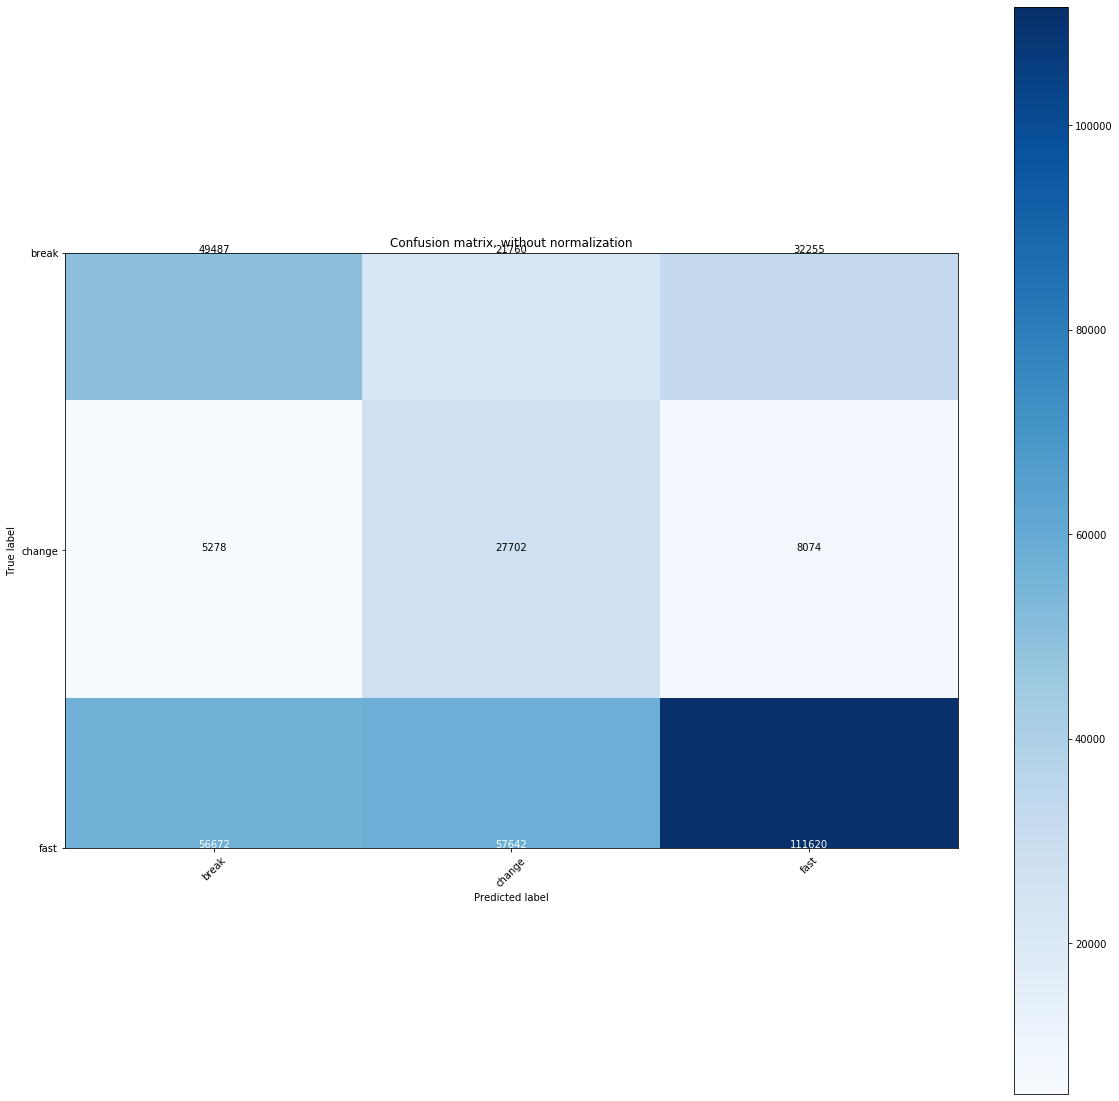

In [201]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=pitch_vals,
                      title='Confusion matrix, without normalization')

In [179]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import matplotlib.pyplot as plt
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')